<a href="https://colab.research.google.com/github/pritkudale/Code_for_LinkedIn/blob/main/Recommendation_system_animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


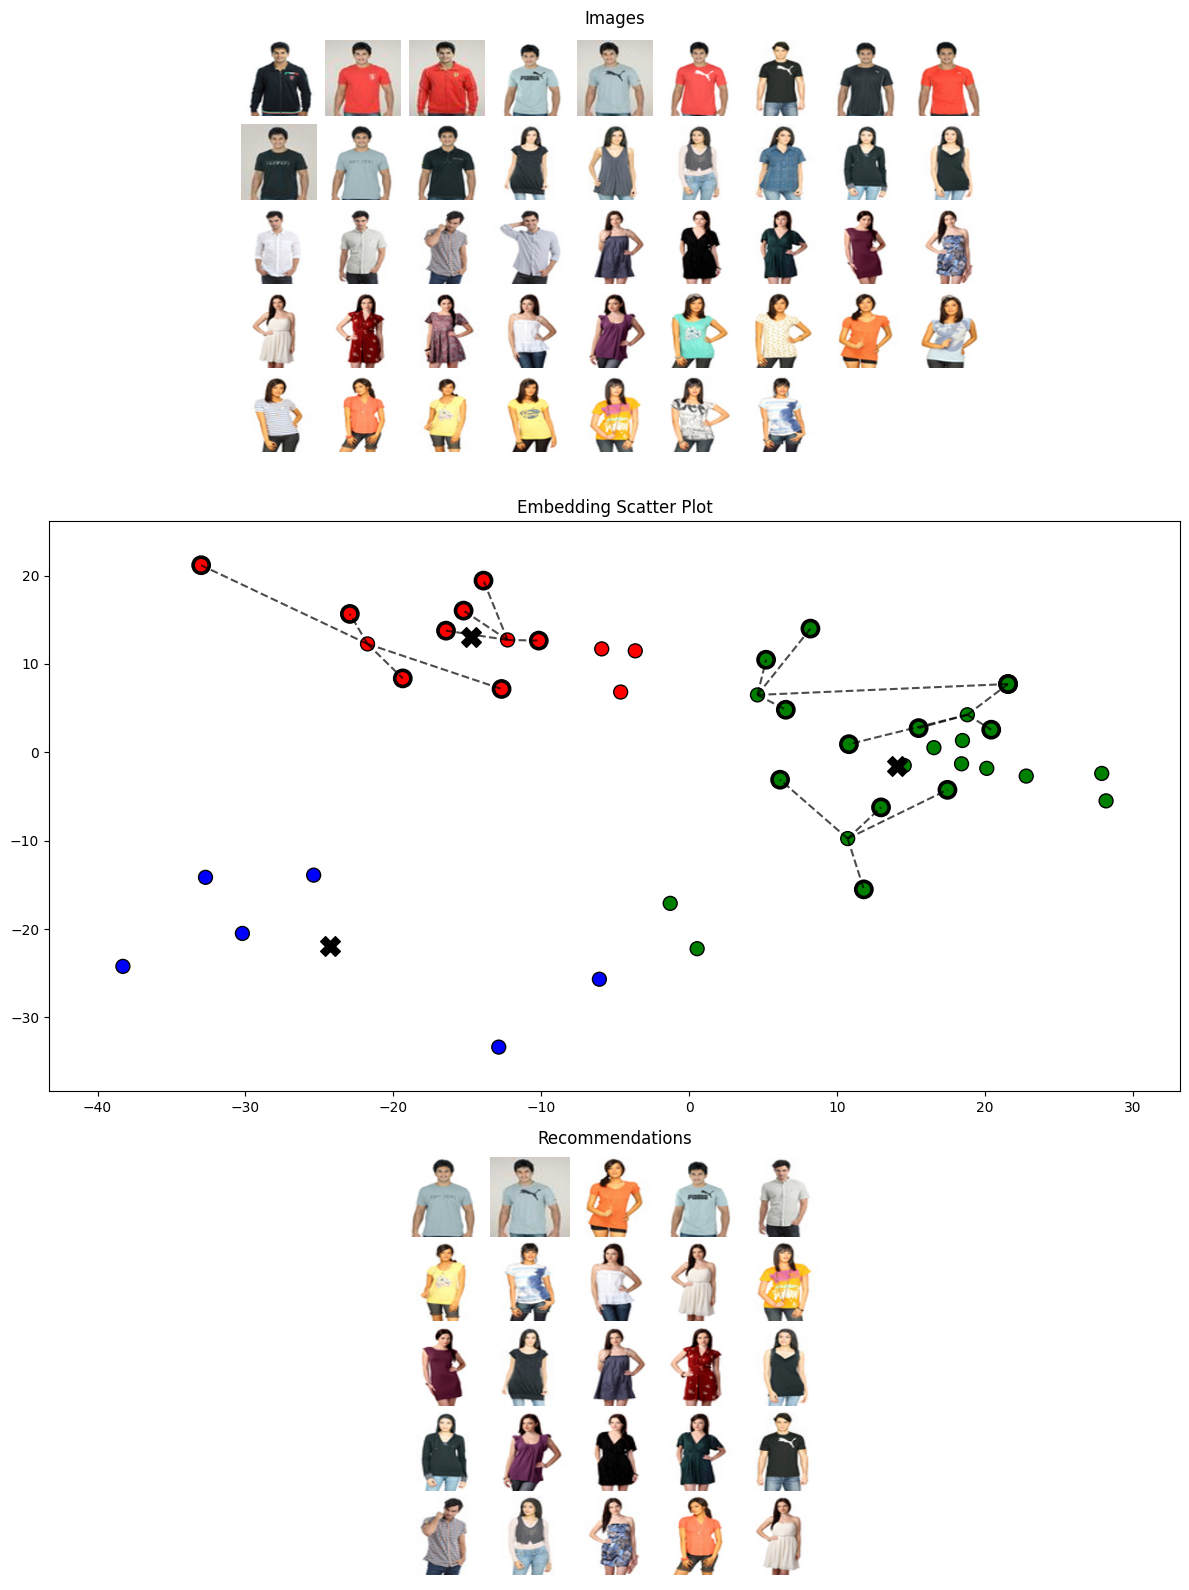

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# --- Configuration ---
image_folder = "/content/drive/MyDrive/Vizuara ai/Vizuara/images"
image_pattern = os.path.join(image_folder, "*.*")

# Define horizontal plot widths (in data coordinates) for the first and third subplots
plot_width = 900          # For the image grid (first subplot)
rec_plot_width = 900      # For the recommendations (third subplot)

grid_cols = 9             # Number of columns in the image grid

# Recommendation grid: 5 rows and 5 columns (each row shows a query image plus its 4 recommendations)
rec_rows = 5
rec_cols = 5
spacing = 10              # Spacing (in data units) between images

# Compute image sizes so that the images span the horizontal extent:
grid_img_width = (plot_width - (grid_cols + 1) * spacing) / grid_cols
grid_img_height = grid_img_width  # Square images assumed

rec_img_width = (rec_plot_width - (rec_cols + 1) * spacing) / rec_cols
rec_img_height = rec_img_width   # Square images assumed

n_clusters = 3          # For clustering in the scatter plot

# --- Load images ---
image_files = sorted(glob.glob(image_pattern))
images = []
for file in image_files:
    try:
        img = Image.open(file).convert("RGB")
        # Resize image to the grid size (which will also be used for recommendations)
        img_resized = img.resize((int(grid_img_width), int(grid_img_height)))
        images.append(np.array(img_resized))
    except Exception as e:
        print(f"Error loading {file}: {e}")

n_images = len(images)
if n_images == 0:
    raise ValueError("No images found in the folder.")

# --- Create improved embeddings using PCA ---
flat_images = np.array([img.flatten()/255.0 for img in images])
pca = PCA(n_components=2, random_state=42)
embeddings = pca.fit_transform(flat_images)

# --- Compute cosine similarity for recommendations ---
similarity_matrix = cosine_similarity(embeddings)
def get_recommendations(index, top_n=4):
    scores = similarity_matrix[index]
    sorted_indices = np.argsort(scores)[::-1][1:top_n+1]  # Exclude self
    return sorted_indices

# Pre-select 5 distinct query images for recommendations (one per recommendation row)
query_indices = np.random.choice(n_images, size=rec_rows, replace=False)

# --- Setup figure and axes ---
# Adjust gridspec ratios so that the middle scatter plot gets a bit more height
fig, axes = plt.subplots(3, 1, figsize=(12, 16), gridspec_kw={'height_ratios': [3, 4, 3]})
ax_images, ax_scatter, ax_recommendations = axes

# --- First subplot: Image Grid (with top margin and upright images) ---
ax_images.set_title("Images")
ax_images.axis("off")
# Compute total grid height: top margin = spacing at top plus spacing at bottom
grid_rows = int(np.ceil(n_images / grid_cols))
total_grid_height = grid_rows * (grid_img_height + spacing) + spacing
# Set the axis so that y=total_grid_height is at the top and 0 at the bottom
ax_images.set_xlim(0, plot_width)
ax_images.set_ylim(0, total_grid_height)

# Compute grid positions so that for each row (r=0 is top row) we place images from top to bottom.
grid_positions = []
for r in range(grid_rows):
    y_top = total_grid_height - r * (grid_img_height + spacing) - spacing
    for c in range(grid_cols):
        idx = r * grid_cols + c
        if idx >= n_images:
            break
        x = spacing + c * (grid_img_width + spacing)
        grid_positions.append((x, y_top - grid_img_height))

# --- Middle subplot: Embedding Scatter Plot ---
ax_scatter.set_title("Embedding Scatter Plot")
x_min, x_max = embeddings[:, 0].min() - 5, embeddings[:, 0].max() + 5
y_min, y_max = embeddings[:, 1].min() - 5, embeddings[:, 1].max() + 5
ax_scatter.set_xlim(x_min, x_max)
ax_scatter.set_ylim(y_min, y_max)

# --- Third subplot: Recommendations Grid (5 rows, 5 columns; with top margin and upright images) ---
ax_recommendations.set_title("Recommendations")
ax_recommendations.axis("off")
total_rec_height = rec_rows * (rec_img_height + spacing) + spacing
ax_recommendations.set_xlim(0, rec_plot_width)
ax_recommendations.set_ylim(0, total_rec_height)

# Compute positions for recommendations (for each row r, with r=0 being the top row)
recommend_positions = []
for r in range(rec_rows):
    y_top = total_rec_height - r * (rec_img_height + spacing) - spacing
    for c in range(rec_cols):
        x = spacing + c * (rec_img_width + spacing)
        recommend_positions.append((x, y_top - rec_img_height))

def update(frame):
    # Clear scatter plot on each update for fresh drawing
    ax_scatter.cla()
    ax_scatter.set_title("Embedding Scatter Plot")
    ax_scatter.set_xlim(x_min, x_max)
    ax_scatter.set_ylim(y_min, y_max)

    # Phase 1: Build image grid and update scatter progressively
    if frame < n_images:
        idx = frame
        x, y = grid_positions[idx]
        extent = [x, x + grid_img_width, y, y + grid_img_height]
        ax_images.imshow(images[idx], extent=extent)

        current_embeddings = embeddings[:idx + 1]
        ax_scatter.scatter(current_embeddings[:, 0], current_embeddings[:, 1], c='gray', s=100)
        ax_scatter.text(embeddings[idx, 0] + 0.5, embeddings[idx, 1] + 0.5, f"{idx}", fontsize=8)
    # Phase 2: After placing all images, perform clustering and then reveal recommendations row by row
    else:
        # Cluster the entire set of embeddings
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_
        cluster_colors = ['red', 'green', 'blue', 'orange', 'purple']
        colors = [cluster_colors[label % len(cluster_colors)] for label in labels]
        ax_scatter.scatter(embeddings[:, 0], embeddings[:, 1], c=colors, s=100, edgecolor='k')
        ax_scatter.scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='X')

        # Determine how many recommendation rows to reveal based on the frame count.
        rec_row_to_show = frame - n_images + 1  # Show one more row per frame
        if rec_row_to_show > rec_rows:
            rec_row_to_show = rec_rows

        # For each recommendation row that should be revealed so far
        for row in range(rec_row_to_show):
            query = query_indices[row]
            recommended_indices = get_recommendations(query)
            # The recommendation row consists of the query and its top 4 recommendations
            rec_indices = [query] + list(recommended_indices)
            for col in range(rec_cols):
                pos_index = row * rec_cols + col
                x, y = recommend_positions[pos_index]
                extent = [x, x + rec_img_width, y, y + rec_img_height]
                ax_recommendations.imshow(images[rec_indices[col]], extent=extent)
                # In the scatter plot, draw dashed lines from query embedding to each recommendation (except self)
                if col > 0:
                    ax_scatter.plot([embeddings[query, 0], embeddings[rec_indices[col], 0]],
                                    [embeddings[query, 1], embeddings[rec_indices[col], 1]],
                                    color='black', linestyle='dashed', alpha=0.7)
                    ax_scatter.scatter(embeddings[rec_indices[col], 0], embeddings[rec_indices[col], 1],
                                       s=150, facecolors='none', edgecolors='black', linewidths=2)
    return []

# --- Create the animation ---
total_frames = n_images + rec_rows  # After all images, each frame adds one recommendation row
ani = animation.FuncAnimation(fig, update, frames=total_frames, interval=500, blit=False, repeat=False)
ani.save('image_embeddings_with_recommendations.gif', writer='imagemagick')

plt.tight_layout()
plt.show()
